# Moisture transport for South America

- Data from ERA-INTERIM.
- Specific humidity and moisture flux.
- Mean trajectories using `cdlearn.trajectories.StaticTrajectory` class.
- Get climatological mean of observed data of water vapour content, NDVI, total precipitation, evaporation along all trajectories.
- The water vapor content $w$ is the vertically integrated water vapor depth (precipitable water) represented by the vertical integral of specific humidity $q(p)$ from the surface to an elevation where pressure $p$ vanish, as follows:
$$
w = \frac{1}{\rho_L g} \int_{p_0}^{0} q(p) dp
$$
where $\rho_L$ is the liquid water density and $g$ is the acceleration due to gravity. The velocity $\pmb{V} = (u, v)$ is defined through the vertically integrated water vapor flux $\pmb{F} = (F_x, F_y)$, as follows:
$$
u = \frac{F_x}{w}; \hspace{1cm} v = \frac{F_y}{w}
$$
and:
$$
F_x = \frac{1}{\rho_L g} \int_{p_0}^{0} q(p) \hat{u}(p) dp ; \hspace{1cm}
F_y = \frac{1}{\rho_L g} \int_{p_0}^{0} q(p) \hat{v}(p) dp
$$
where $\hat{u}(p)$ and $\hat{v}(p)$ are the wind components in the $x$ and $y$
directions, respectively.
- Scatter plots of precipitation vs vegetation (**TO BE DONE**).

## 1 Initial setup

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from dask.diagnostics import ProgressBar
from matplotlib.ticker import MultipleLocator

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib inline

In [4]:
# First we will use cartopy's shapereader to download (and cache) 
# states shapefile with 50 meters resolution from the NaturalEarth.
kw = dict(
    resolution="50m", 
    category="cultural", 
    name="admin_1_states_provinces"
)
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

In [5]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, -60, 20 # Latitude in ascending order.

# Time range. 
ti, tf = "1981-07", "2012-09"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [6]:
# Main folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/"

# Moisture transport data folder.
MOISTURE_FOLDER = DATA_FOLDER + "ERA_INTERIM/moisture_transport_mmeans/"

# NDVI data folder.
VEGETATION_FOLDER = DATA_FOLDER + "GIMMS/NDVI_mmeans/"

# Total precipitation data folder.
PRECIPITATION_FOLDER = DATA_FOLDER + "ERA_INTERIM/total_precipitation_mmeans/"

# Evaporation data folder.
EVAPORATION_FOLDER = DATA_FOLDER + "ERA_INTERIM/evaporation_mmeans/"

# Where put results for trajectories.
TRAJECTORIES_FOLDER = DATA_FOLDER + "TRAJECTORIES/ensemble2/"

## 2 Load and preprocess data

### 2.1 Moisture transport

In [7]:
# List files.
MOISTURE_FILES = sorted(glob.glob(MOISTURE_FOLDER + "*.grb"))

In [8]:
%%time

# DataSets objects.
DS_mt = xr.open_mfdataset(MOISTURE_FILES, engine="cfgrib", concat_dim="time")

CPU times: user 1min 13s, sys: 936 ms, total: 1min 14s
Wall time: 1min 27s


In [9]:
%%time

# Shift longitudes and guarantee time ordering. 
# Latitude is also put in ascending order.
DS_mt = DS_mt.assign_coords(longitude=(DS_mt.longitude + 180) % 360 - 180)
DS_mt = DS_mt.sortby(DS_mt.latitude)
DS_mt = DS_mt.sortby(DS_mt.longitude)
DS_mt = DS_mt.sortby(DS_mt.time)

CPU times: user 75 ms, sys: 4.06 ms, total: 79.1 ms
Wall time: 115 ms


In [10]:
# South America at commom time range.
DS_mt = DS_mt.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)

In [11]:
%%time

# Let's rename some variables.
DS_mt = DS_mt.rename(
    name_dict={"v": "w", 
               "q": "Uwind",     
               "sp": "Vwind", 
               "stl1": "Fx", 
               "swl1": "Fy"}
)

# Names and units for variables.
long_names = [
    "specific humidity [kg/m2]", 
    "zonal wind [kg/m/s]",
    "meridional wind [kg/m/s]",
    "zonal moisture flux [kg/m/s]",
    "meridional moisture flux [kg/m/s]"
]

# Put them as attributes.
for var_name, long_name in zip(DS_mt.data_vars.keys(), long_names):
    DS_mt[var_name].attrs = {}
    DS_mt[var_name].attrs["long_name"] = long_name

CPU times: user 1.17 ms, sys: 25 µs, total: 1.2 ms
Wall time: 1.21 ms


**I have some doubts about units.**

In [12]:
# Calculate velocities of air masses.
DS_mt = DS_mt.assign(u = DS_mt.Fx / DS_mt.w, v = DS_mt.Fy / DS_mt.w)

In [13]:
# Load into memory.
with ProgressBar():
    DS_mt = DS_mt.compute()

[########################################] | 100% Completed | 24.1s


In [14]:
# Put land-sea mask.
DS_mt = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_mt)

### 2.2 NDVI

In [15]:
# List files.
VEGETATION_FILES = sorted(glob.glob(VEGETATION_FOLDER + "*.nc4"))

In [16]:
%%time

# Lazy read of global data sets.
DS_ndvi = xr.open_mfdataset(VEGETATION_FILES, concat_dim="time")

# Latitude in ascending order.
DS_ndvi = DS_ndvi.sortby(DS_ndvi.latitude)

CPU times: user 679 ms, sys: 36.3 ms, total: 715 ms
Wall time: 1.3 s


In [17]:
# South America at commom time range.
DS_ndvi = DS_ndvi.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)

In [18]:
# Load into memory.
with ProgressBar():
    DS_ndvi = DS_ndvi.compute()

[########################################] | 100% Completed |  3.2s


In [19]:
# Put mask.
DS_ndvi = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_ndvi)

### 2.3 Total precipitation

In [20]:
# List files.
PRECIPITATION_FILES = sorted(glob.glob(PRECIPITATION_FOLDER + "*.grb"))

In [21]:
%%time

# DataSets objects.
DS_tp = xr.open_mfdataset(PRECIPITATION_FILES, engine="cfgrib", concat_dim="time")

CPU times: user 2.1 s, sys: 66.8 ms, total: 2.17 s
Wall time: 3.51 s


In [22]:
%%time

# Shift longitudes and guarantee time ordering.
# Latitude is also put in ascending order.
DS_tp = DS_tp.assign_coords(longitude=(DS_tp.longitude + 180) % 360 - 180)
DS_tp = DS_tp.sortby(DS_tp.latitude)
DS_tp = DS_tp.sortby(DS_tp.longitude)
DS_tp = DS_tp.sortby(DS_tp.time)

CPU times: user 19.4 ms, sys: 162 µs, total: 19.6 ms
Wall time: 22.7 ms


In [23]:
# South America at commom time range.
DS_tp = DS_tp.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)

In [24]:
# Load into memory.
with ProgressBar():
    DS_tp = DS_tp.compute()

[########################################] | 100% Completed |  4.9s


In [25]:
# Put land-sea mask.
DS_tp = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_tp)

### 2.4 Evaporation

In [26]:
# List files.
EVAPORATION_FILES = sorted(glob.glob(EVAPORATION_FOLDER + "*.grb"))

In [27]:
%%time

# DataSets object.
DS_e = xr.open_mfdataset(EVAPORATION_FILES, engine="cfgrib", concat_dim="time")

CPU times: user 2.28 s, sys: 23.9 ms, total: 2.3 s
Wall time: 3.67 s


In [28]:
%%time

# Shift longitudes and guarantee time ordering.
# Latitude is also put in ascending order.
DS_e = DS_e.assign_coords(longitude=(DS_e.longitude + 180) % 360 - 180)
DS_e = DS_e.sortby(DS_e.latitude)
DS_e = DS_e.sortby(DS_e.longitude)
DS_e = DS_e.sortby(DS_e.time)

CPU times: user 13.2 ms, sys: 54 µs, total: 13.3 ms
Wall time: 12.7 ms


In [29]:
# South America at commom time range.
DS_e = DS_e.sel(
    longitude=slice(loni, lonf), latitude=slice(lati, latf), time=slice(ti, tf)
)

**CAUTION HERE!: we change the sign of evaporation! Now it is positive!**

In [30]:
DS_e = (-1.0) * DS_e

In [31]:
# Load into memory.
with ProgressBar():
    DS_e = DS_e.compute()

[########################################] | 100% Completed |  6.8s


In [32]:
# Put land-sea mask.
DS_e = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_e)

## 3 Show me the data

### 3.1 Mean for the whole period

CPU times: user 1.24 s, sys: 120 ms, total: 1.36 s
Wall time: 2.84 s


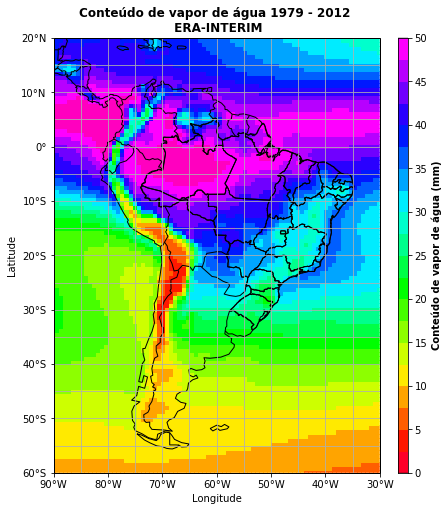

In [33]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 1),
    axes_pad=0.02,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, lati, latf], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    p = DS_mt.w.mean("time").plot(
        ax=axis,
        vmin=0,
        vmax=50,
        levels=np.arange(0, 50 + 2.5, 2.5),
        cmap=plt.cm.gist_rainbow,
        add_colorbar=False,
        add_labels=False
    )
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Conteúdo de vapor de água 1979 - 2012 \n ERA-INTERIM", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Conteúdo de vapor de água (mm)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 50  + 5, 5))

# Save figures.
plt.savefig(fig_path + "specific_humidity_erainterim_mean_pt.jpg", 
            dpi=200, bbox_inches="tight")

CPU times: user 1.87 s, sys: 379 ms, total: 2.25 s
Wall time: 4.56 s


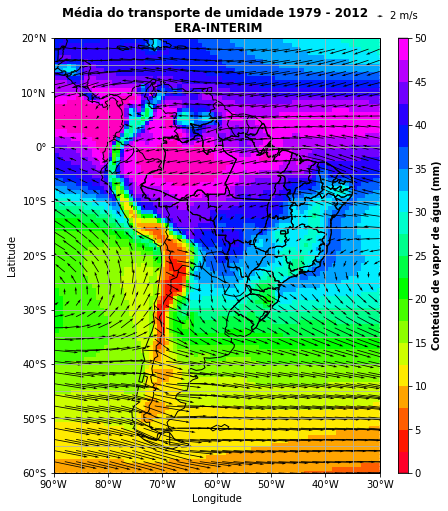

In [34]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 1),
    axes_pad=0.02,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, lati, latf], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot scalar data on this map.
    p = DS_mt.w.mean("time").plot(
        ax=axis,
        vmin=0,
        vmax=50,
        levels=np.arange(0, 50 + 2.5, 2.5),
        cmap=plt.cm.gist_rainbow,
        add_colorbar=False,
        add_labels=False
    )
    
    # Plot vectorial data on this map.
    x = DS_mt.longitude.values; y = DS_mt.latitude.values;
    X, Y = np.meshgrid(x, y)
    Fx = DS_mt.u.mean("time").values
    Fy = DS_mt.v.mean("time").values
    scale = (1 / 3) * np.median(np.sqrt(Fx ** 2 + Fy ** 2).flatten())
    scale_str = str("%.0f" %scale)
    Q = axis.quiver(
        X, Y, Fx, Fy, transform=projection, units="xy", regrid_shape=30, scale=scale
    )
    QK = axis.quiverkey(
        Q, 1.01, 1.05, scale, scale_str + " " + "m/s", labelpos="E"
    )
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Média do transporte de umidade 1979 - 2012 \n ERA-INTERIM", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Conteúdo de vapor de água (mm)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 50  + 5, 5))

# Save figures.
plt.savefig(fig_path + "specific_humidity_and_moisture_flux_erainterim_mean_pt.jpg", 
            dpi=200, bbox_inches="tight")

### 3.2 Monthly means

In [35]:
# Monthly means.
DA_w_mm = DS_mt.w.groupby("time.month").mean("time")
DA_Fx_mm = DS_mt.Fx.groupby("time.month").mean("time")
DA_Fy_mm = DS_mt.Fy.groupby("time.month").mean("time")
DA_u_mm = DS_mt.u.groupby("time.month").mean("time")
DA_v_mm = DS_mt.v.groupby("time.month").mean("time")
DA_ndvi_mm = DS_ndvi.ndvi.groupby("time.month").mean("time")
DA_tp_mm = DS_tp.tp.groupby("time.month").mean("time")
DA_e_mm = DS_e.e.groupby("time.month").mean("time")

>>> Processing Janeiro ...
>>> Processing Fevereiro ...
>>> Processing Março ...
>>> Processing Abril ...
>>> Processing Maio ...
>>> Processing Junho ...
>>> Processing Julho ...
>>> Processing Agosto ...
>>> Processing Setembro ...
>>> Processing Outubro ...
>>> Processing Novembro ...
>>> Processing Dezembro ...
CPU times: user 20.2 s, sys: 6.31 s, total: 26.5 s
Wall time: 19.5 s


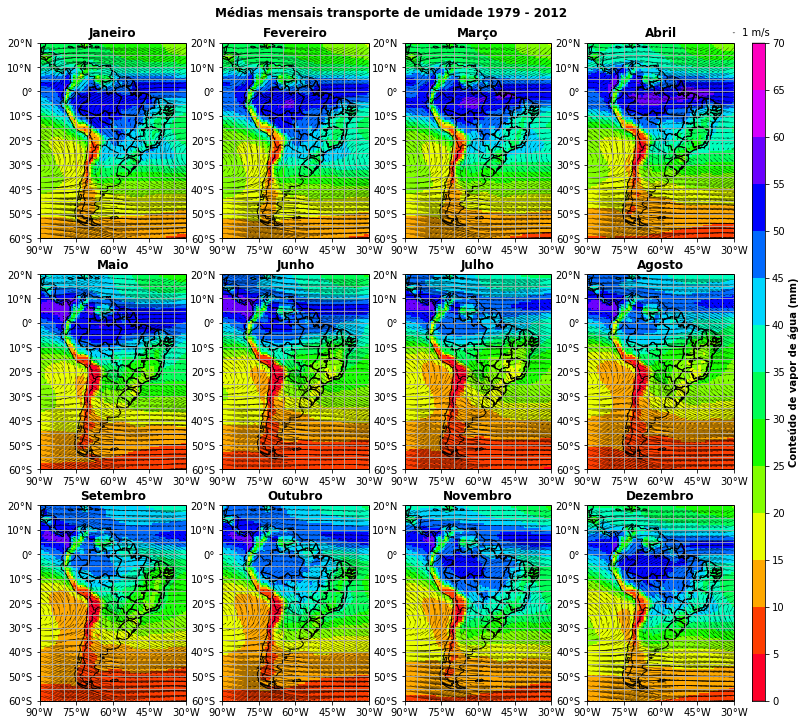

In [36]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(13, 12))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 4),
    axes_pad=0.5,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    
    print(">>> Processing", cdlearn.auxiliary.months_labels_pt[index], "...")
    
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = DA_w_mm[index].plot(
        ax=axis,
        vmin=0,
        vmax=75,
        levels=np.arange(0, 70 + 5, 5),
        cmap=plt.cm.gist_rainbow,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(cdlearn.auxiliary.months_labels_pt[index], weight="bold")
    
    # Plot vectorial data on this map.
    # Scale is calculated based on January.
    if index == 0:
        x = DS_mt.longitude.values; y = DS_mt.latitude.values;
        X, Y = np.meshgrid(x, y)
        Fx = DA_u_mm.isel(month=index).values
        Fy = DA_v_mm.isel(month=index).values
        scale = (1 / 5) * np.median(np.sqrt(Fx ** 2 + Fy ** 2).flatten())
        scale_str = str("%.0f" %scale)
    
    Fx = DA_u_mm.isel(month=index).values
    Fy = DA_v_mm.isel(month=index).values
    Q = axis.quiver(X, Y, Fx, Fy, transform=projection, units="xy", regrid_shape=30, 
                    scale=scale)
    
    # Label apears in the fourth plot.
    if index == 3:
        QK = axis.quiverkey(
            Q, 1.01, 1.05, scale, scale_str + " " + "m/s", labelpos="E"
        )  

    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Conteúdo de vapor de água (mm)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 70 + 5, 5)) 
plt.suptitle("Médias mensais transporte de umidade 1979 - 2012", weight="bold")
plt.subplots_adjust(top=0.99) 

# Save figures.
plt.savefig(fig_path + "specific_humidity_and_moisture_flux_erainterim_mmeans_pt.jpg", 
            dpi=200, bbox_inches="tight")

## 4 Static trajectories

### 4.1 Mean for the whole period

>>> Trajectory running free ...


100% (864 of 864) |######################| Elapsed Time: 0:00:03 ETA:  00:00:00

>>> Trajectory running free ...


100% (864 of 864) |######################| Elapsed Time: 0:00:07 ETA:  00:00:00

>>> Trajectory running free ...


100% (864 of 864) |######################| Elapsed Time: 0:00:09 ETA:  00:00:00

>>> Trajectory running free ...


100% (864 of 864) |######################| Elapsed Time: 0:00:07 ETA:  00:00:00

>>> Trajectory running free ...


100% (864 of 864) |######################| Elapsed Time: 0:00:04 ETA:  00:00:00

>>> Trajectory running free ...


 98% (854 of 864) |##################### | Elapsed Time: 0:00:03 ETA:   0:00:00

>>> Trajectory running free ...


 98% (854 of 864) |##################### | Elapsed Time: 0:00:03 ETA:   0:00:00

>>> Trajectory running free ...


100% (864 of 864) |######################| Elapsed Time: 0:00:03 ETA:  00:00:00

CPU times: user 37.1 s, sys: 838 ms, total: 38 s
Wall time: 53 s


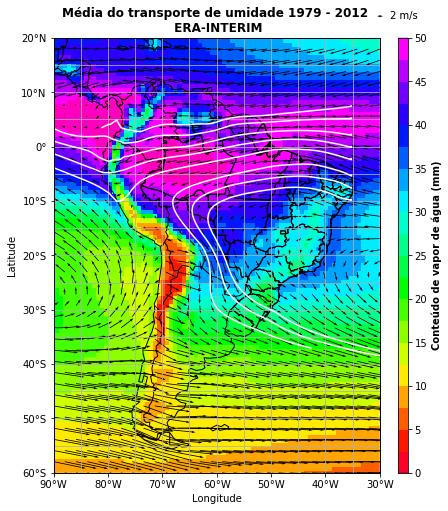

In [37]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 1),
    axes_pad=0.02,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, lati, latf], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot scalar data on this map.
    p = DS_mt.w.mean("time").plot(
        ax=axis,
        vmin=0,
        vmax=50,
        levels=np.arange(0, 50 + 2.5, 2.5),
        cmap=plt.cm.gist_rainbow,
        add_colorbar=False,
        add_labels=False
    )
    
    # Plot vectorial data on this map.
    x = DS_mt.longitude.values; y = DS_mt.latitude.values;
    X, Y = np.meshgrid(x, y)
    Fx = DS_mt.u.mean("time").values
    Fy = DS_mt.v.mean("time").values
    scale = (1 / 3) * np.median(np.sqrt(Fx ** 2 + Fy ** 2).flatten())
    scale_str = str("%.0f" %scale)
    Q = axis.quiver(
        X, Y, Fx, Fy, transform=projection, units="xy", regrid_shape=30, scale=scale
    )
    QK = axis.quiverkey(
        Q, 1.01, 1.05, scale, scale_str + " " + "m/s", labelpos="E"
    )
    
    # Trajectories over an ensemble of initial positions.
    UU = DS_mt.u.mean("time")
    VV = DS_mt.v.mean("time")
    
    p0s = [np.array([-10, -35]), 
           np.array([-7.5, -35]), 
           np.array([-5, -35]), 
           np.array([-2.5, -35]), 
           np.array([0, -35]), 
           np.array([2.5, -35]), 
           np.array([5, -35]), 
           np.array([7.5, -35])]
    
    for p0 in p0s:
       
        trajectory = cdlearn.trajectories.StaticTrajectory(
            U=UU, V=VV, angular_position0=p0
        )
        tra = trajectory.run(dt=2500, T=25*24*60*60, verbose=True)
        axis.plot(tra.longitude, tra.latitude, color="white", transform=projection)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Média do transporte de umidade 1979 - 2012 \n ERA-INTERIM", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Conteúdo de vapor de água (mm)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 50  + 5, 5));

# Save figures.
plt.savefig(fig_path + "specific_humidity_and_moisture_flux_erainterim_mean_tra_pt.jpg", 
            dpi=200, bbox_inches="tight")

### 4.2 Climatological monthly means

>>> Processing Janeiro ...
>>> Processing Fevereiro ...
>>> Processing Março ...
>>> Processing Abril ...
>>> Processing Maio ...
>>> Processing Junho ...
>>> Processing Julho ...
>>> Processing Agosto ...
>>> Processing Setembro ...
>>> Processing Outubro ...
>>> Processing Novembro ...
>>> Processing Dezembro ...
CPU times: user 16min 35s, sys: 8.1 s, total: 16min 43s
Wall time: 17min 2s


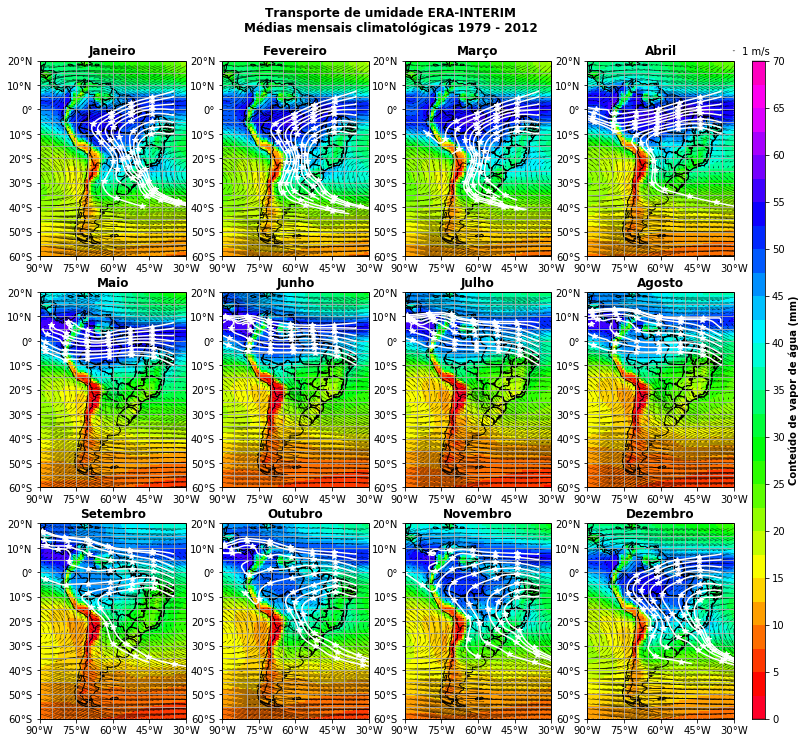

In [38]:
%%time

# Time integration parameters.
dt = 2500        # Time step.
T = 28*24*60*60  # 28 days.

# This date is just a dummy index.
time0 = "climatological"

# Skeleton for South America maps.
axgr = cdlearn.maps.south_america_months()

# Put climatological trajectories here.
trajectories_dict = {}

# Climatological mean of trajectories for each month.
for index, axis in enumerate(axgr):
        
    print(">>> Processing", cdlearn.auxiliary.months_labels_pt[index], "...")        
        
    # Plot data on these maps.
    p = DA_w_mm[index].plot(
        ax=axis,
        vmin=0,
        vmax=75,
        levels=np.arange(0, 70.0 + 2.5, 2.5),
        cmap=plt.cm.gist_rainbow,
        add_colorbar=False,
        add_labels=False
    )    
    
    axis.set_title(cdlearn.auxiliary.months_labels_pt[index], weight="bold")
    
    # Month string (01, 02, ..., 12).    
    month_str = str("%02d" %(index + 1))    

    # Plot vectorial data on this map.
    # Scale is calculated based on January.
    if index == 0:
        x = DS_mt.longitude.values; y = DS_mt.latitude.values;
        X, Y = np.meshgrid(x, y)
        Fx = DA_u_mm.isel(month=index).values
        Fy = DA_v_mm.isel(month=index).values
        scale = (1 / 5) * np.median(np.sqrt(Fx ** 2 + Fy ** 2).flatten())
        scale_str = str("%.0f" %scale)
    
    Fx = DA_u_mm.isel(month=index).values
    Fy = DA_v_mm.isel(month=index).values
    Q = axis.quiver(X, Y, Fx, Fy, transform=projection, units="xy", regrid_shape=30, 
                    scale=scale)    
 
    # Label apears in the fourth plot.
    if index == 3:
        QK = axis.quiverkey(
            Q, 1.01, 1.05, scale, scale_str + " " + "m/s", labelpos="E"
        )  

    # Trajectories for each month.
    U = DA_u_mm.isel(month=index)
    V = DA_v_mm.isel(month=index)
    
    for p0 in p0s:
    
        # Initialize trajectory.
        st = cdlearn.trajectories.StaticTrajectory(
            U=U, 
            V=V, 
            angular_position0=p0
        )
    
        # Run trajectory.
        df_trajectory = st.run(dt=dt, T=T)
    
        # Water vapour content along trajectory.
        df_trajectory = st.add_data_along_trajectory(
            df_trajectory=df_trajectory,
            data_array=DA_w_mm.isel(month=index).where(DA_w_mm.land_mask==True),
            var_name="w"
        )
        
        # NDVI data along trajectory.
        df_trajectory = st.add_data_along_trajectory(
            df_trajectory=df_trajectory,
            data_array=DA_ndvi_mm.isel(month=index).where(DA_ndvi_mm.land_mask==True),
            var_name="ndvi"
        )
        
        # Total precipitation data along trajectory.
        df_trajectory = st.add_data_along_trajectory(
            df_trajectory=df_trajectory,
            data_array=DA_tp_mm.isel(month=index).where(DA_tp_mm.land_mask==True),
            var_name="tp"
        )        
        
        # Evaporation data along trajectory.
        df_trajectory = st.add_data_along_trajectory(
            df_trajectory=df_trajectory,
            data_array=DA_e_mm.isel(month=index).where(DA_e_mm.land_mask==True),
            var_name="e"
        )                
        
        # Plot trajectories.
        axgr = cdlearn.maps.draw_trajectory(
            df_trajectory=df_trajectory,
            axgr=axgr,
            axgr_index=index,    
            color="white",
            show_stars=True
        )        
        
        # Put results in this dictionary.
        key = "month" + str("_%02d" %(index + 1)) + "_pos0_" + str("%05.2f_%05.2f" %(p0[0], p0[1]))
        trajectories_dict[key] = df_trajectory
        
        # Save trajectories in csv files.
        df_trajectory.to_csv(path_or_buf=TRAJECTORIES_FOLDER + key + ".csv")    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Conteúdo de vapor de água (mm)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(0, 70 + 5, 5)) 
plt.suptitle(
    "Transporte de umidade ERA-INTERIM\n" + \
    "Médias mensais climatológicas 1979 - 2012", weight="bold")
plt.subplots_adjust(top=0.948) 

# Save figures.
plt.savefig(fig_path + "specific_humidity_and_moisture_flux_erainterim_mmeans_tra_pt.jpg", 
            dpi=200, bbox_inches="tight")          

### 4.3 Data along these trajectories (for each month)

>>> 8 trajectories!
CPU times: user 3.32 s, sys: 401 ms, total: 3.72 s
Wall time: 2.99 s


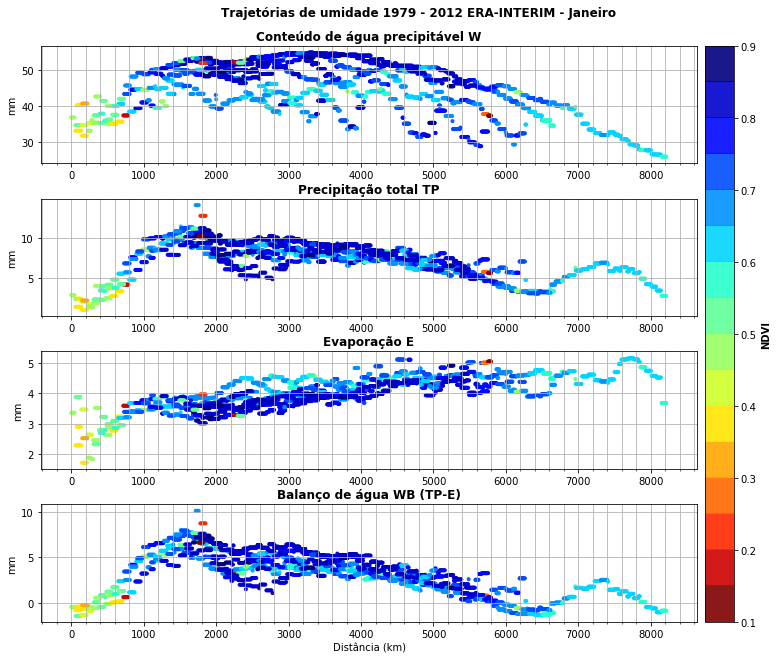

In [39]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for January.
count = 0
for key in trajectories_dict.keys():
    
    if "_01_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Janeiro", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_01_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 3.43 s, sys: 492 ms, total: 3.92 s
Wall time: 3.03 s


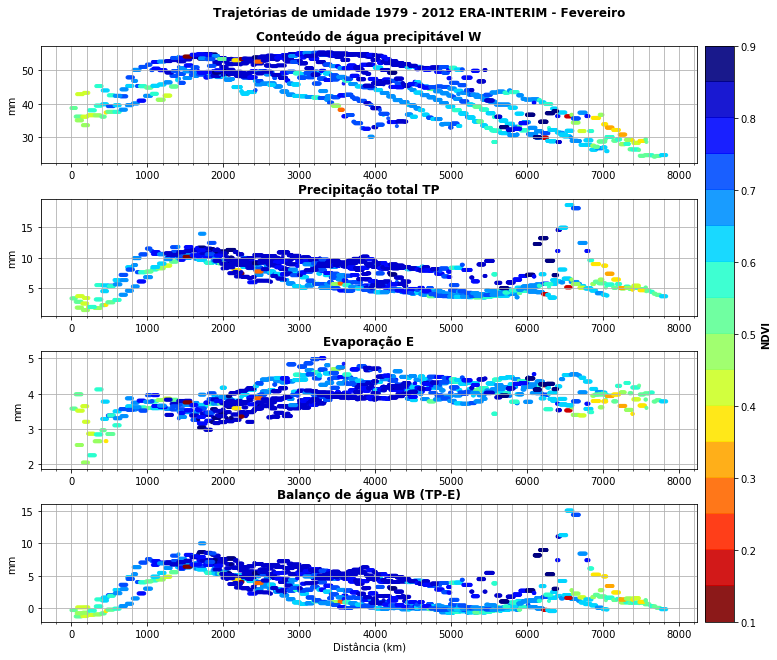

In [40]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for February.
count = 0
for key in trajectories_dict.keys():
    
    if "_02_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Fevereiro", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_02_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 3.19 s, sys: 341 ms, total: 3.53 s
Wall time: 2.98 s


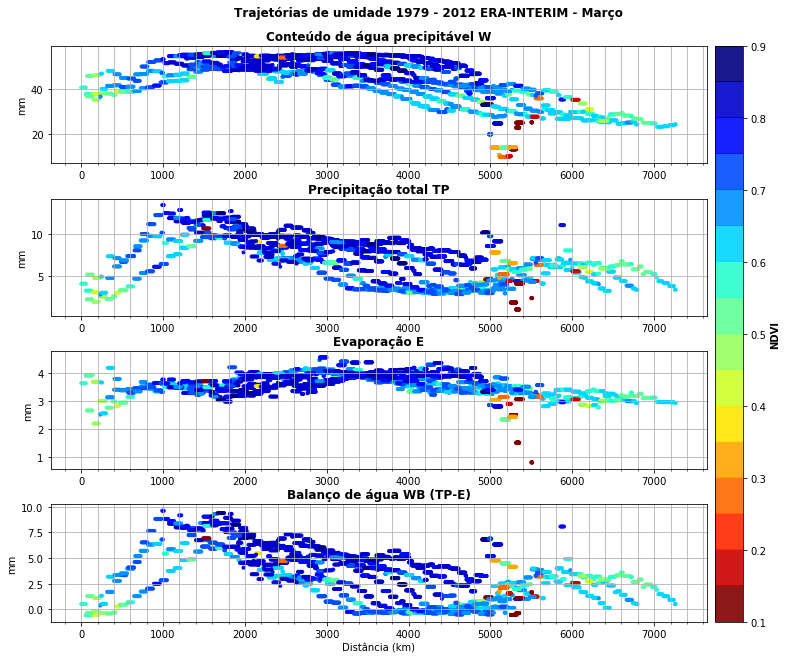

In [41]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for March.
count = 0
for key in trajectories_dict.keys():
    
    if "_03_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Março", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_03_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 2.98 s, sys: 360 ms, total: 3.34 s
Wall time: 2.65 s


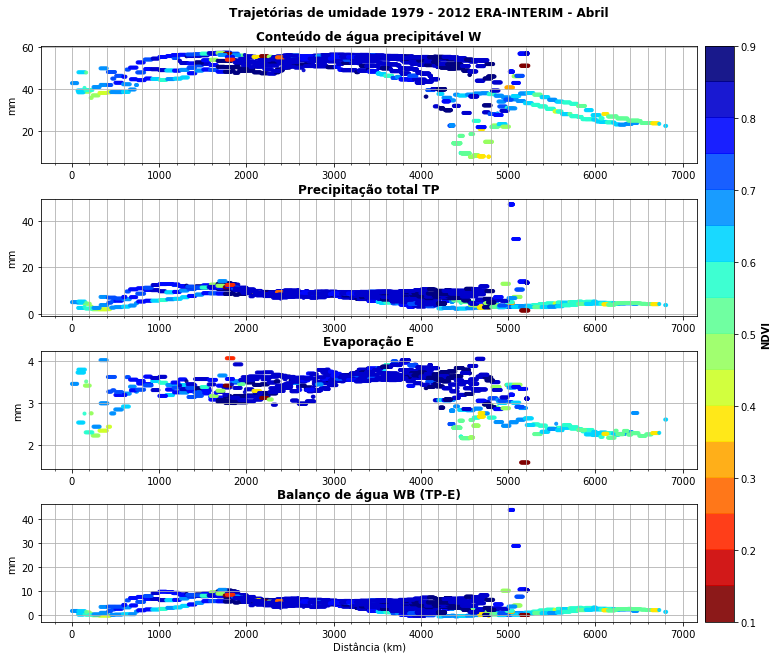

In [42]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for April.
count = 0
for key in trajectories_dict.keys():
    
    if "_04_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Abril", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_04_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 2.86 s, sys: 361 ms, total: 3.22 s
Wall time: 2.42 s


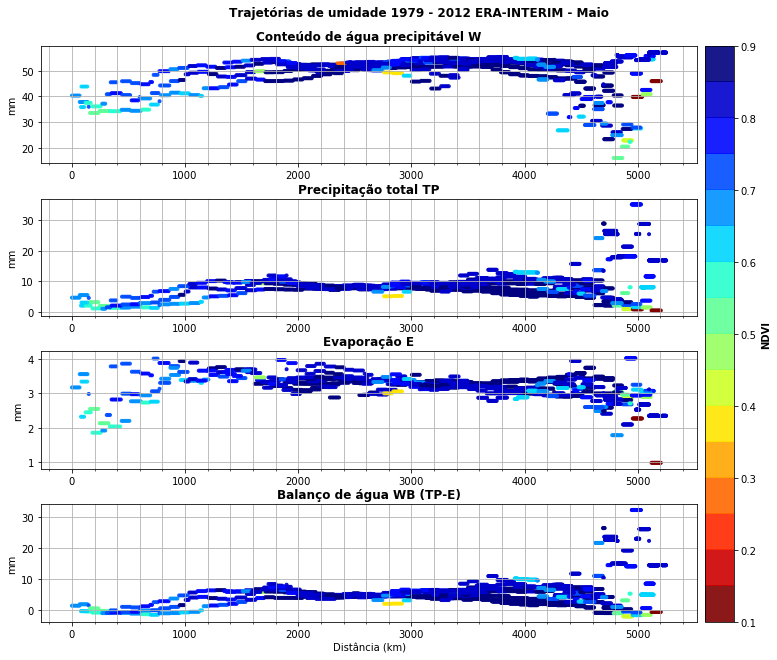

In [43]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for May.
count = 0
for key in trajectories_dict.keys():
    
    if "_05_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Maio", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_05_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 2.98 s, sys: 401 ms, total: 3.38 s
Wall time: 2.6 s


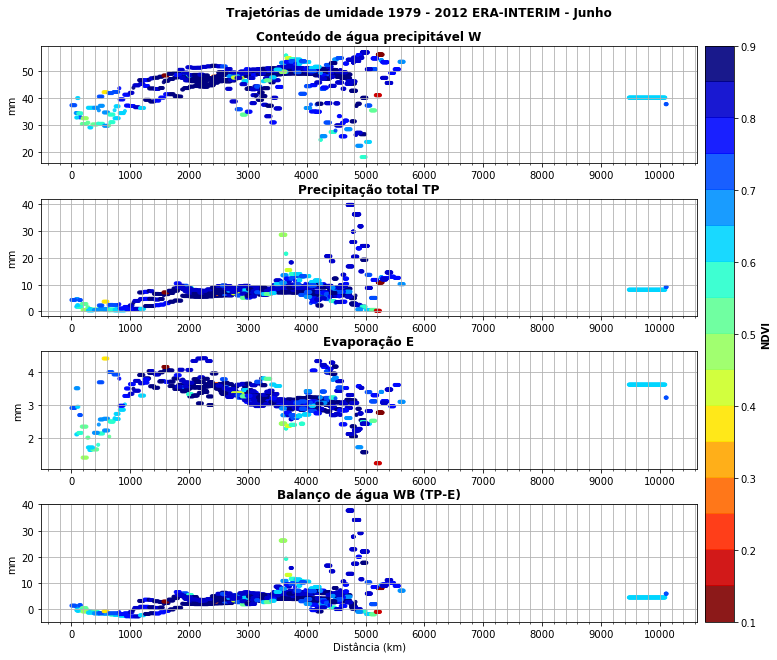

In [44]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for June.
count = 0
for key in trajectories_dict.keys():
    
    if "_06_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Junho", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_06_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 2.52 s, sys: 300 ms, total: 2.82 s
Wall time: 2.17 s


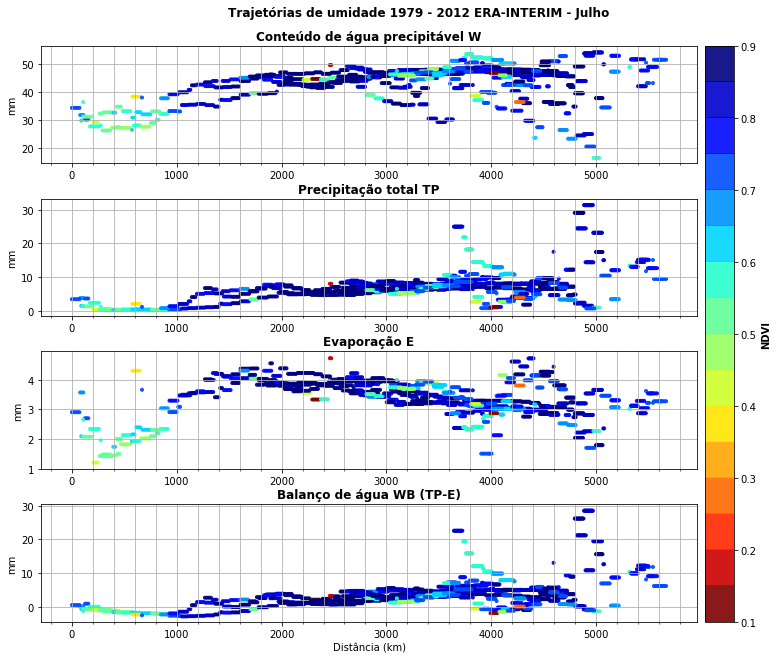

In [45]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for July.
count = 0
for key in trajectories_dict.keys():
    
    if "_07_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Julho", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_07_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 2.63 s, sys: 389 ms, total: 3.02 s
Wall time: 2.23 s


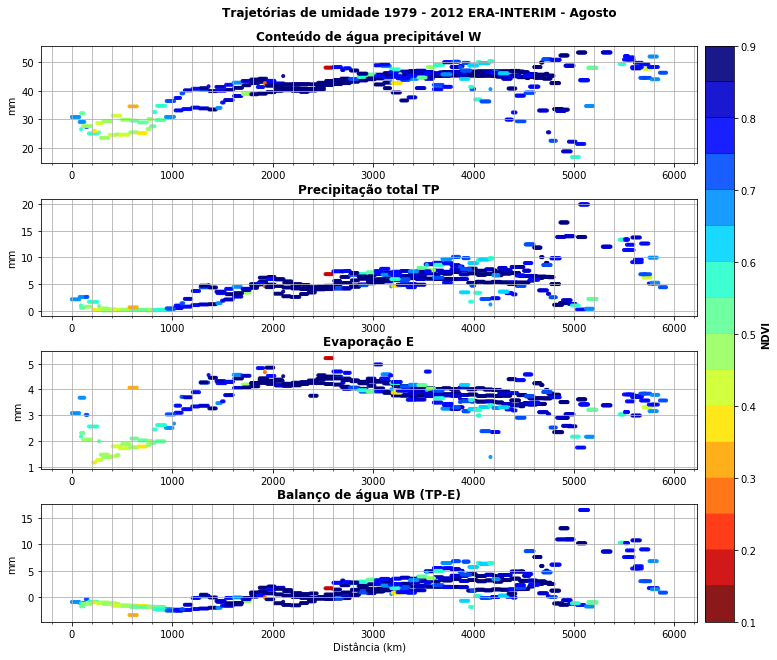

In [46]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for August.
count = 0
for key in trajectories_dict.keys():
    
    if "_08_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Agosto", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_08_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 3.35 s, sys: 413 ms, total: 3.76 s
Wall time: 2.96 s


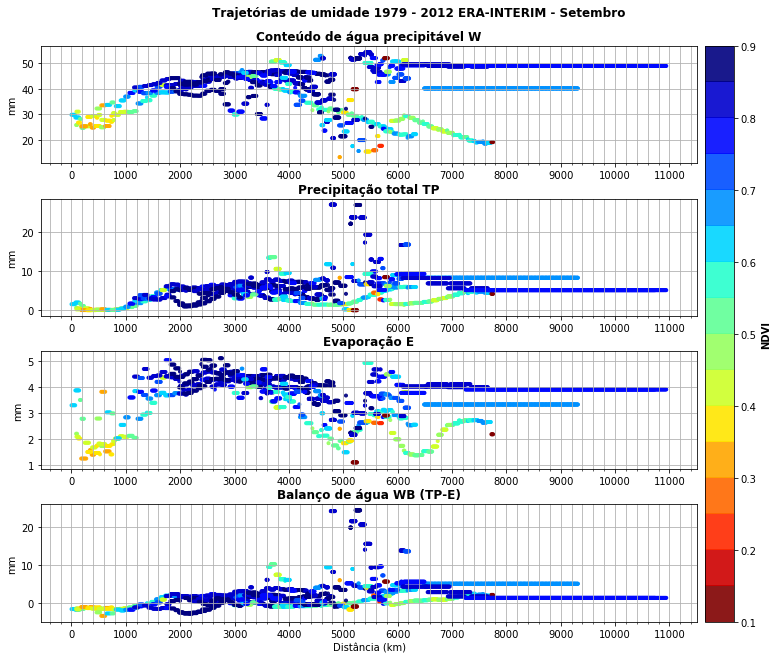

In [47]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for September.
count = 0
for key in trajectories_dict.keys():
    
    if "_09_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Setembro", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_09_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 2.89 s, sys: 364 ms, total: 3.26 s
Wall time: 2.45 s


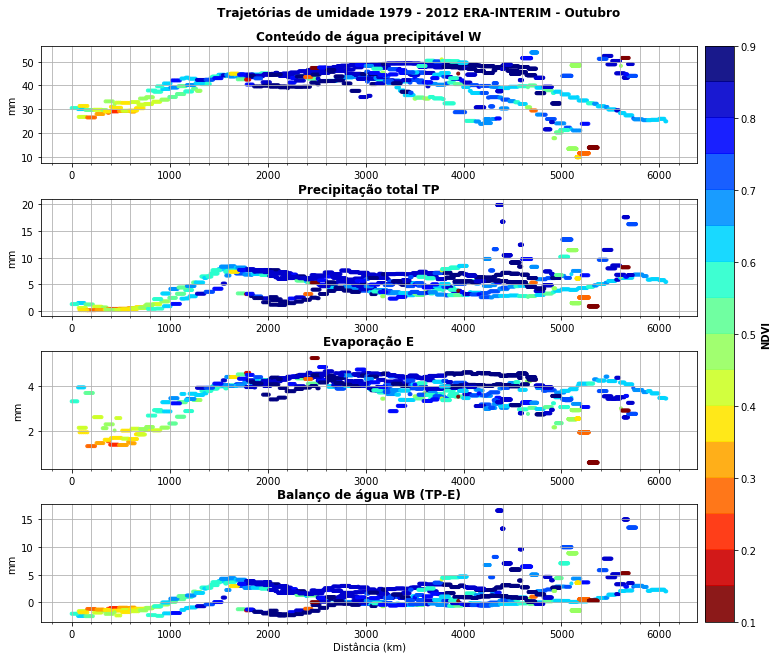

In [48]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for October.
count = 0
for key in trajectories_dict.keys():
    
    if "_10_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Outubro", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_10_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 4.09 s, sys: 393 ms, total: 4.48 s
Wall time: 4.08 s


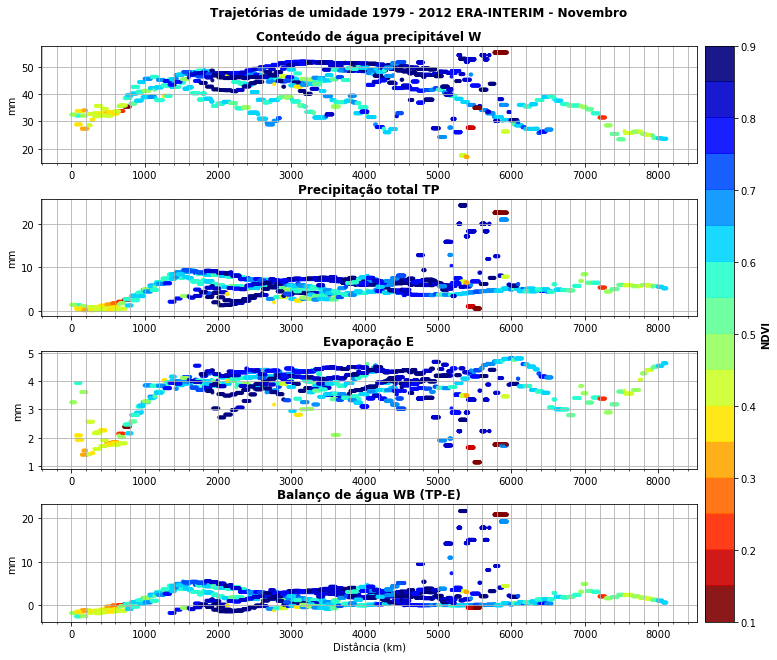

In [58]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for November.
count = 0
for key in trajectories_dict.keys():
    
    if "_11_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Novembro", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_11_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 8 trajectories!
CPU times: user 3.05 s, sys: 365 ms, total: 3.41 s
Wall time: 2.78 s


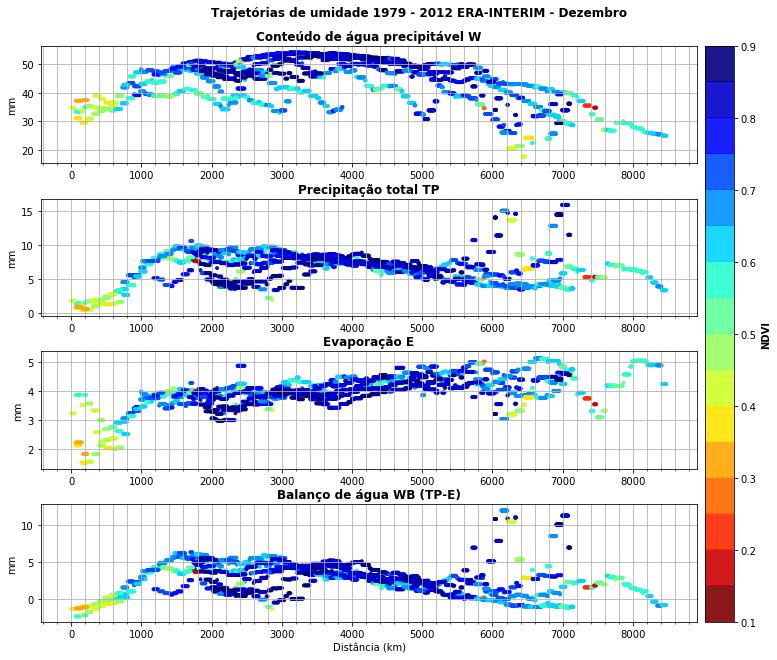

In [50]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for December.
count = 0
for key in trajectories_dict.keys():
    
    if "_12_" in key:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.925)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM - Dezembro", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_12_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

### 4.4 Data along these trajectories (rainy and dry seasons)

In [69]:
# Put together trajectories of rainy season.
rains = ["_12_", "_01_", "_02_"]

# Put together trajectories of dry season.
drys = ["_06_", "_07_", "_08_"]

>>> 24 trajectories!
CPU times: user 7.03 s, sys: 871 ms, total: 7.9 s
Wall time: 6.03 s


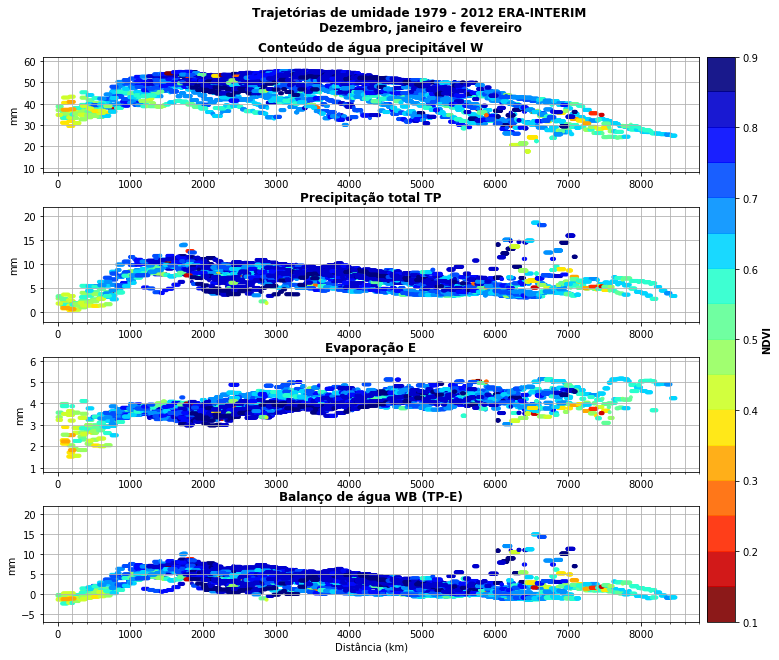

In [94]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for rainy season.
count = 0
for key in trajectories_dict.keys():
    
    i = key.find("_")
    month_str = key[i: i + 4] 
    
    if month_str in rains:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
        axes[0].set_ylim((8, 62))
        axes[0].yaxis.set_major_locator(MultipleLocator(10))
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
        axes[1].set_ylim((-2, 22))
        axes[1].yaxis.set_major_locator(MultipleLocator(5))        
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        axes[2].set_ylim((0.8, 6.2))
        axes[2].yaxis.set_major_locator(MultipleLocator(1))          
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
        axes[3].set_ylim((-7, 22))
        axes[3].yaxis.set_major_locator(MultipleLocator(5))            
            
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.91)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM \nDezembro, janeiro e fevereiro", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")   
    axis.set_xlim((-200, 8800))

# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_rainy_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")

>>> 24 trajectories!
CPU times: user 4.54 s, sys: 686 ms, total: 5.23 s
Wall time: 4.01 s


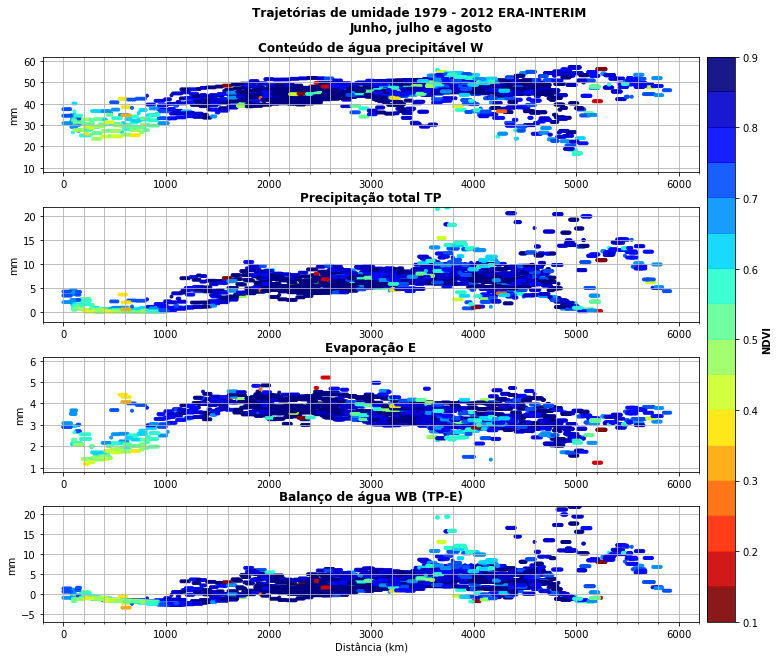

In [93]:
%%time

# Prepare figure.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10))

# All trajectories for dry season.
count = 0
for key in trajectories_dict.keys():
    
    i = key.find("_")
    month_str = key[i: i + 4] 
    
    if month_str in drys:
        
        count += 1
        
        # Extract data.
        df_trajectory = trajectories_dict[key]
        
        # Scatter plot for precipitable water content.
        sc = axes[0].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.w,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )
         
        axes[0].set_title("Conteúdo de água precipitável W", weight="bold")   
        axes[0].set_ylabel("mm")
        axes[0].set_ylim((8, 62))
        axes[0].yaxis.set_major_locator(MultipleLocator(10))
            
        # Scatter plot for total precipitation.
        axes[1].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.tp * 1000,
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
            
        axes[1].set_title("Precipitação total TP", weight="bold")    
        axes[1].set_ylabel("mm")    
        axes[1].set_ylim((-2, 22))
        axes[1].yaxis.set_major_locator(MultipleLocator(5))              
            
        # Scatter plot for evaporation.
        axes[2].scatter(
            x=df_trajectory.distance / 1000, 
            y=df_trajectory.e * (1000),
            c=df_trajectory.ndvi,
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )    
        
        axes[2].set_title("Evaporação E", weight="bold")
        axes[2].set_ylabel("mm")
        axes[2].set_ylim((0.8, 6.2))
        axes[2].yaxis.set_major_locator(MultipleLocator(1))           
        
        # Scatter plot for (precipitation - evaporation).
        axes[3].scatter(
            x=df_trajectory.distance / 1000, 
            y=(df_trajectory.tp*1000 - df_trajectory.e*1000), # Evaporation is now positive!
            c=df_trajectory.ndvi,                             # I have switched the sign above!
            cmap=plt.cm.get_cmap("jet_r", 16),
            vmin=0.1, 
            vmax=0.9,
            alpha=0.9,
            marker=".",
            edgecolors="face" 
        )            
        
        axes[3].set_title("Balanço de água WB (TP-E)", weight="bold")
        axes[3].set_ylabel("mm")    
        axes[3].set_ylim((-7, 22))
        axes[3].yaxis.set_major_locator(MultipleLocator(5))       
    
# Adjustments.        
plt.subplots_adjust(hspace=0.30, top=0.91)
plt.suptitle(
    "Trajetórias de umidade 1979 - 2012 ERA-INTERIM \nJunho, julho e agosto", 
    weight="bold"
)
        
# Add colorbar for NDVI.
cbar = fig.colorbar(sc, ax=axes, pad=0.01)
cbar.set_ticks(np.arange(0.1, 1.0, 0.1))
cbar.set_label("NDVI", weight="bold")

# More adjustments.
axes[-1].set_xlabel("Distância (km)")
for axis in axes:
    axis.xaxis.set_major_locator(MultipleLocator(1000))
    axis.xaxis.set_minor_locator(MultipleLocator(200))
    axis.grid(which="both")
    axis.set_xlim((-200, 6200))
    
# Save figures.
plt.savefig(
    fig_path + "data_along_tra_climatology_dry_pt.jpg", 
    dpi=200, 
    bbox_inches="tight"
)       

# Sanity check!
print(">>> " + str(count) + " trajectories!")